In [3]:
from imports import *

def compute_cv(neurons,metadata,stru,types,start = 0,stop = None,binSize = 1,nbins = None):
    activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == types)], start=start, stop=stop,binSize = binSize,nbins = nbins, as_Tsd=True)
    
    cv = (np.std(activity.values,1) / np.mean(activity.values,1))*100
    # cv = nts.Tsd(activity.times(),cv)

    return cv

def cv_intervals(neurons,metadata,stru,types,intervals,nbins,norm = False,baseline = None):
    if len(intervals) == 0:
        eib = np.empty(shape = nbins)
        eib.fill(np.nan)
        return eib
    if norm:
        if baseline is None:
            tmp_eib = compute_cv(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru)
        else:
            tmp_eib = compute_cv(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru,as_tsd=True).restrict(baseline)
        mean = np.nanmean(tmp_eib)
        std = np.nanstd(tmp_eib)

    intervals_eib_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        eib_ = compute_cv(neurons,metadata,stru,types,start = s,stop = e,nbins = nbins)

        if norm: eib_ = (eib_-mean)/std

        intervals_eib_matrix.append(eib_)
    if nbins == 1:
        intervals_eib_matrix = np.hstack(intervals_eib_matrix)
    return intervals_eib_matrix

In [4]:
def main(base_folder, local_path, *args, **kwargs):
    stru = kwargs['stru']
    types = kwargs['types']
    min_neurons = kwargs['min_neurons']
    nbins = kwargs['nbins']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']
    norm = kwargs['norm']
    baseline = kwargs['baseline']


    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    states = bk.load.states(True)
    # Remove wake and drowsy intervals as they are not intereting here 
    for s in ['wake', 'drowsy']:
        states.pop(s)
    
    if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<min_neurons:
        raise Exception('Not Enough Neurons')

    cv = {}
    df = pd.DataFrame()
    for k, state in states.items():
        # We remove what is close to transition as the sleep scoring might not be perfect
        bk.misc.discard_border(state, time_from_border[k])
        state = state.drop_short_intervals(min_duration_epoch[k], 's').reset_index(drop=True)
        cv[k] = cv_intervals(neurons, metadata, stru, types, state,nbins[k],norm,baseline)
        if nbins[k] == 1:  
            df_ = pd.DataFrame(cv[k],columns=['EIB'])
        elif nbins[k]==3:
            df_ = pd.DataFrame(cv[k],columns=['First','Middle','Last'])
        else:
            df_ = pd.DataFrame([cv[k]]).T
            df_.columns = ['Dynamic']        
        
        df_['State'] = k
        df = pd.concat((df,df_))
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    return df

In [88]:
kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'nbins':
          {
              'NREM': 1,
              'REM': 1,
              'WAKE_HOMECAGE': 1
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons': 11,
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0
           },
          'norm': False,
          'baseline':None
          }
bk.load.current_session_linux()
# main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main, **kwargs)
df = pd.concat(batch)
df = df.reset_index(names = ['session','.'])

  2%|▏         | 1/61 [00:01<01:23,  1.39s/it]

Loading Data from Rat08-20130709
Rat : 8 on day : 2
Working with session Rat08-20130709 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130709
Data already saved in Numpy format, loading them from here:
Rat08-20130709-neurons.npy


KruskalResult(statistic=378.6773552324398, pvalue=5.9055058004800654e-83)
                       NREM           REM  WAKE_HOMECAGE
NREM           1.000000e+00  7.840290e-16   7.400818e-84
REM            7.840290e-16  1.000000e+00   1.282928e-27
WAKE_HOMECAGE  7.400818e-84  1.282928e-27   1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.121e-36 U_stat=2.176e+04
NREM vs. REM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.036e-21 U_stat=4.354e+04
NREM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.931e-72 U_stat=1.398e+04


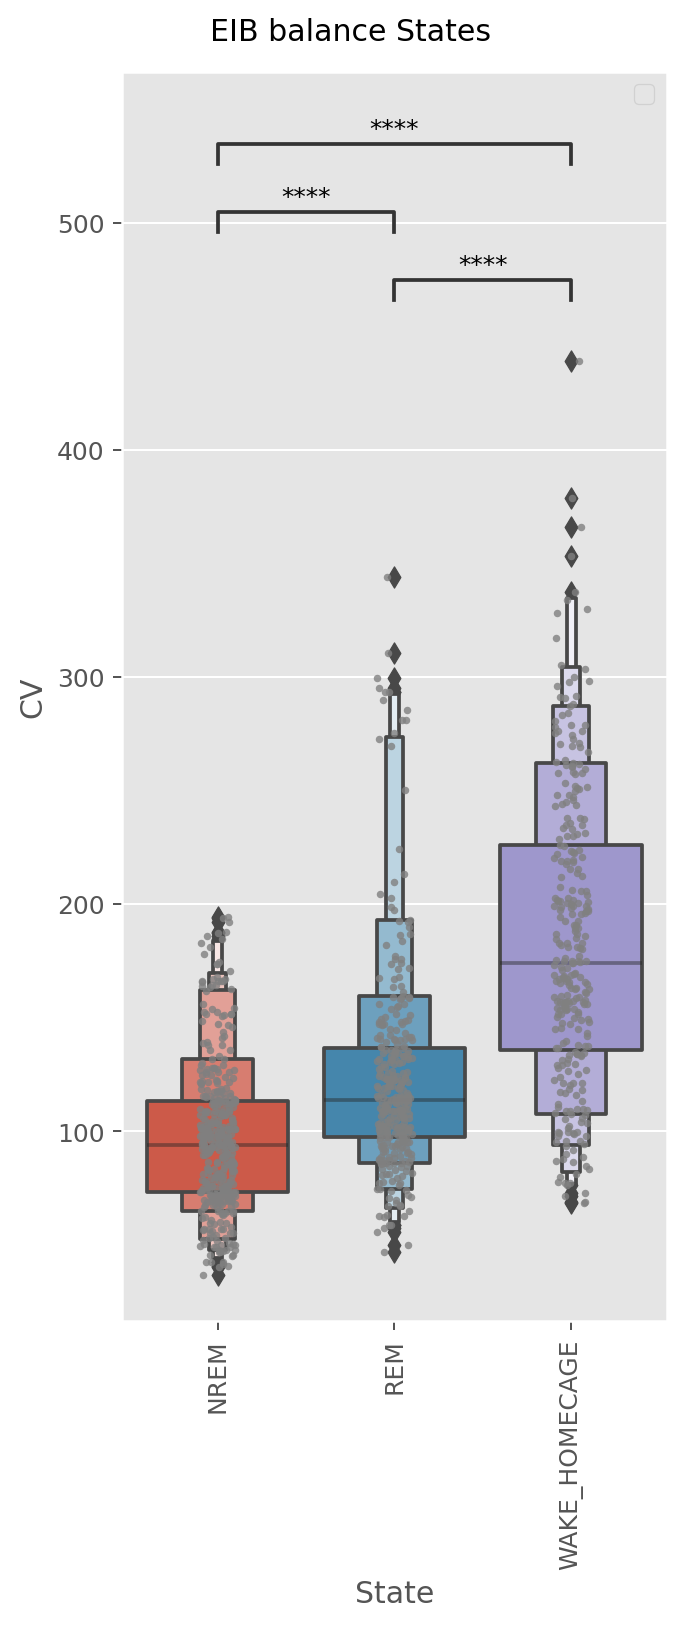

In [79]:
print(scipy.stats.kruskal(df['CV'][df.State == 'NREM'],
                    df['CV'][df.State == 'REM'],
                    df['CV'][df.State == 'WAKE_HOMECAGE']))
pairs = list(itertools.combinations(df.State.unique(),2))
df.groupby('State').apply(lambda x:len(x))
print(sp.posthoc_dunn(df,group_col='State',val_col='CV',p_adjust='bonferroni'))

fig, ax = plt.subplots(1, 1, dpi=180, figsize=(4,8))
plotting_params = {'data': df,
                   'y': 'CV',
                   'x': 'State',
                   'order': ['NREM', 'REM', 'WAKE_HOMECAGE'],
                   'ax': ax}

sns.boxenplot(**plotting_params)
sns.stripplot(**plotting_params, color='grey', size=3, alpha=0.8)
annotator = Annotator(pairs=pairs, **plotting_params)
annotator.configure(test="Mann-Whitney",
                    comparisons_correction='Bonferroni').apply_and_annotate()
plt.suptitle('EIB balance States')
ax.legend([])
plt.tight_layout()
plt.xticks(rotation='vertical')
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/CV/Parts/eib_states.svg')

In [7]:
kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'nbins':
          {
              'NREM': 3,
              'REM': 3,
              'WAKE_HOMECAGE': 3
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons': 11,
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': False,
          'baseline':None
          }
bk.load.current_session_linux()
# main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main, **kwargs)


100%|██████████| 61/61 [01:14<00:00,  1.22s/it]

Batch finished in 74.59631514549255
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
45.90163934426229 %


In [22]:
df = pd.concat(batch)
df = df.reset_index(names = ['session','.'])

NREM FriedmanchisquareResult(statistic=83.2787723785168, pvalue=8.246019323235257e-19)
REM FriedmanchisquareResult(statistic=6.498360655737542, pvalue=0.038806002998317976)
WAKE_HOMECAGE FriedmanchisquareResult(statistic=0.6807017543860638, pvalue=0.7115206225992834)
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NREM_First vs. NREM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.154e-16 Stat=1.950e+04
NREM_Middle vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.846e-02 Stat=3.345e+04
NREM_First vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.023e-17 Stat=1.887e+04


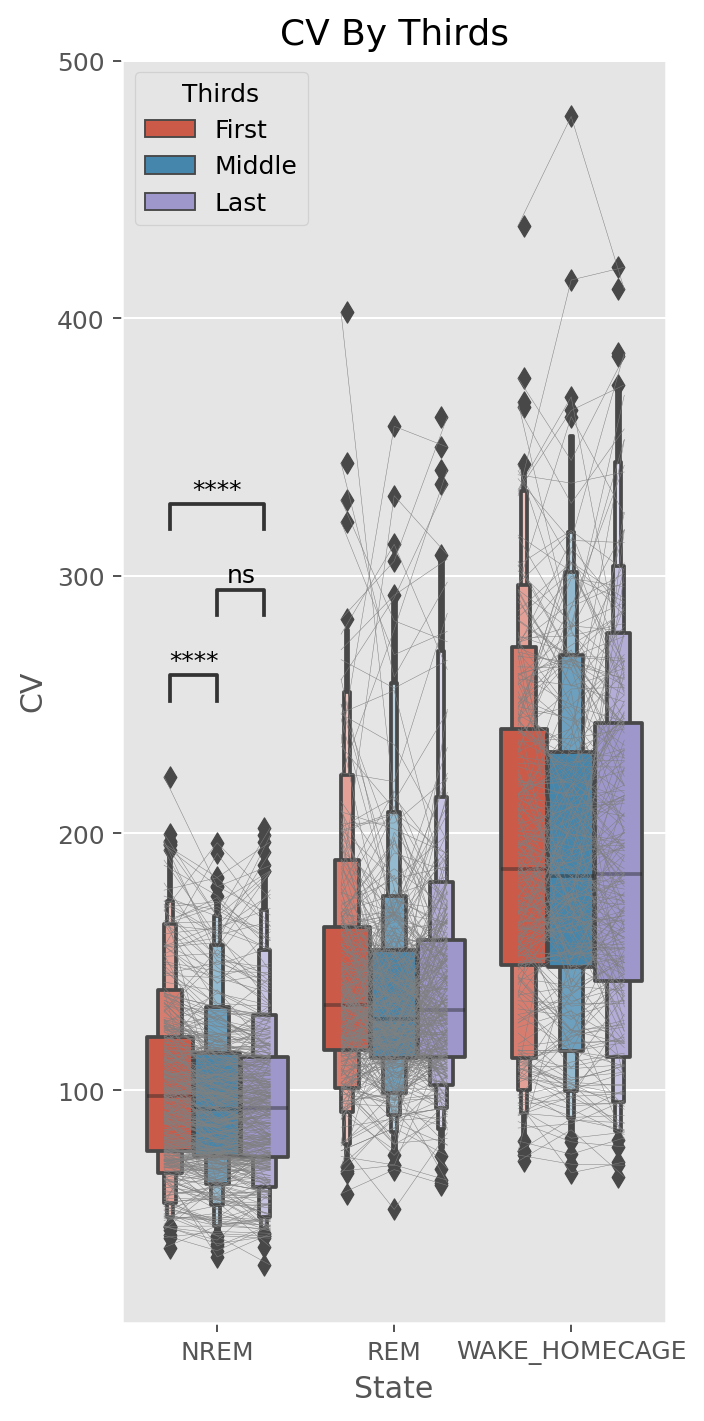

In [23]:
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    print(state,scipy.stats.friedmanchisquare(df['First'][df.State == state],
                                  df['Middle'][df.State == state],
                                  df['Last'][df.State == state]))

pairs = [
    [('NREM', 'First'), ('NREM', 'Middle')],
    [('NREM', 'First'), ('NREM', 'Last')],
    [('NREM', 'Middle'), ('NREM', 'Last')],

    # [('REM', 'First'), ('REM', 'Middle')],
    # [('REM', 'First'), ('REM', 'Last')],
    # [('REM', 'Middle'), ('REM', 'Last')],

    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Middle')],
    # [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Last')],
    # [('WAKE_HOMECAGE', 'Middle'), ('WAKE_HOMECAGE', 'Last')]
]


df_melt = df.melt(id_vars=['Rat','Day','State'],var_name='Thirds',value_name='CV',value_vars=['First','Middle','Last'])
fig,ax = plt.subplots(1,1,figsize=(4,8),dpi = 180)
plotting_params = {'data': df_melt,
                   'y': 'CV',
                   'x':'State',
                   'dodge':True,
                   'hue':'Thirds',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}
sns.boxenplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Wilcoxon",comparisons_correction = 'Bonferroni').apply_and_annotate()

for i,s in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    values = np.array((df.First[df.State == s],df.Middle[df.State == s],df.Last[df.State == s]))
    n_values = values.shape[1]
    
    args_sampling = np.random.choice(n_values,n_values,replace=False)
    x = np.array([[i-0.30]*n_values,[i]*n_values,[i+0.30]*n_values])
    plt.plot(x[:,args_sampling],values[:,args_sampling],'grey',linewidth =0.2)

plt.title(f'CV By Thirds')
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/CV/Parts/eib_state_thirds.svg')

In [25]:
kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'nbins':
          {
              'NREM': 30,
              'REM': 12,
              'WAKE_HOMECAGE': 30
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'min_neurons': 11,
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': False,
          'baseline':None
          }
bk.load.current_session_linux()
# main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
# batch, metadata = bk.load.batch(main, **kwargs)


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


True

NREM
R2 0.004068731625502111
pValue (bonfer) 1.4063405700958645e-11
REM
R2 2.8646725436381962e-05
pValue (bonfer) 2.2385123188232745
WAKE_HOMECAGE
R2 0.00011779610982696464
pValue (bonfer) 0.9469244089769426


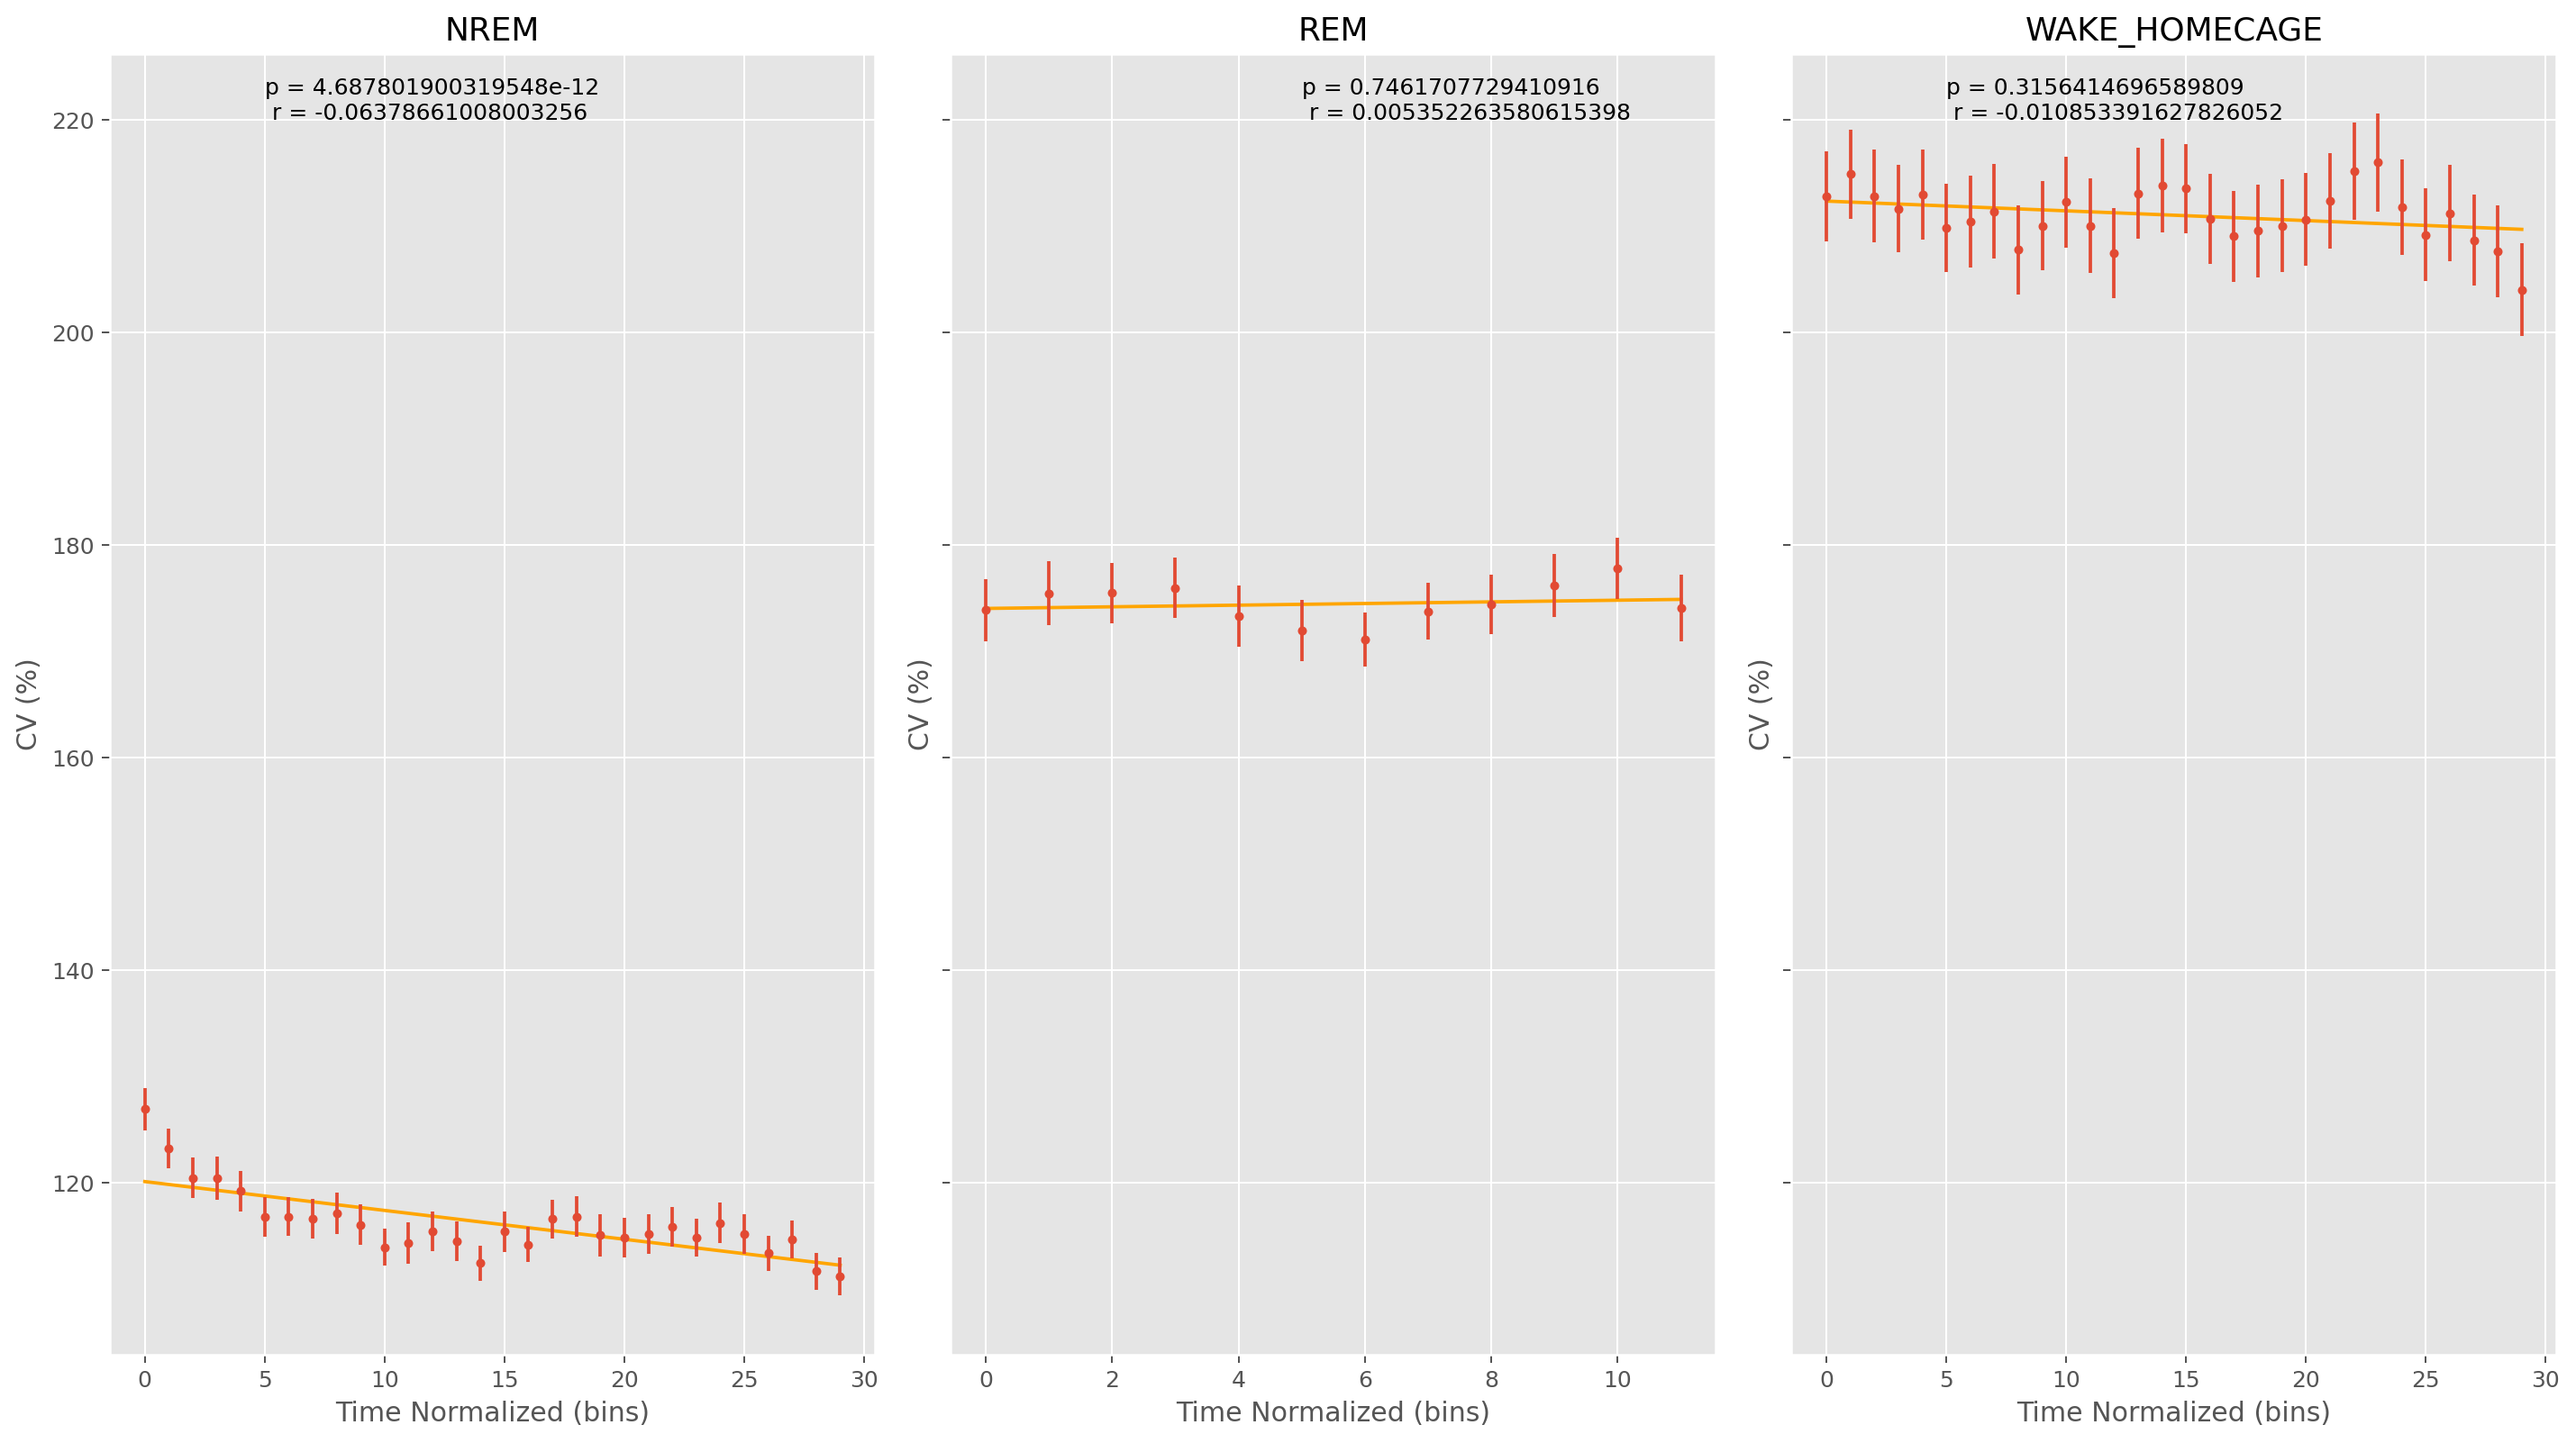

In [30]:
df = pd.concat(batch)
df = df.reset_index(names = ['session','.'])
fig,ax = plt.subplots(1,3,dpi = 180,sharey=True,figsize = (16,9))
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = np.vstack(df.Dynamic[df.State == state].values)
    x = range(y.shape[1])

    # bk.plot.curve_and_shades(range(y.shape[1]),y,'sem',ax=ax[i])
    all_cv = np.array([[],[]])
    for j in y:
        all_cv = np.hstack((all_cv,np.array([x,j])))
        # ax[i].scatter(x,j,color = 'grey')
    

    means = [np.mean(all_cv[1,:][np.where(all_cv[0,:] == i)])for i in x]
    std = [scipy.stats.sem(all_cv[1,:][np.where(all_cv[0,:] == i)])for i in x]
    reg = scipy.stats.linregress(all_cv)


    print(state)
    print('R2',reg.rvalue**2)
    print('pValue (bonfer)',reg.pvalue*3)

    reg_y = (reg.slope * x) + reg.intercept
    ax[i].plot(x,reg_y,'orange')
    ax[i].errorbar(x,means,std,linestyle='None', marker='.')
    
    ax[i].set_title(state)
    ax[i].text(5,220,f'p = {reg.pvalue}\n r = {reg.rvalue}')
    ax[i].set_xlabel('Time Normalized (bins)')
    ax[i].set_ylabel('CV (%)')
plt.tight_layout()
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/CV/Parts/EIB_state_dynamic.svg')

In [7]:
def main(base_folder, local_path, *args, **kwargs):
    stru = kwargs['stru']
    types = kwargs['types']
    norm = kwargs['norm']
    baseline = kwargs['baseline']
    min_neurons = kwargs['min_neurons']

    bk.load.current_session_linux(
        base_folder=base_folder, local_path=local_path)
    neurons, metadata = bk.load.spikes()

    if len(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')]) < min_neurons:
        raise Exception('Not Enough Neurons')

    # if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<11:
    #     raise Exception('Not Enough Neurons')

    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states, 'sleep', 60*30, 60)

    if baseline == 'All':
        baseline_intervals = states['REM'].union(
            states['REM']).union(states['WAKE_HOMECAGE'])
    elif baseline is not None:
        baseline_intervals = states[baseline]
    else:
        baseline_intervals = None
    if norm:
        baseline_eib = compute_cv(neurons, metadata, start=0, stop=None,
                                  binSize=10, stru=stru, as_tsd=True).restrict(baseline_intervals)
        mean = np.nanmean(baseline_eib)
        std = np.nanstd(baseline_eib)

    for s in ['wake', 'drowsy']:
        states.pop(s)

    df = pd.DataFrame()
    for state in ['NREM', 'REM']:
        for s, e in extended_sleep.iloc:
            current_sleep = nts.IntervalSet(s, e)
            first = states[state].intersect(current_sleep)[0:1]
            last = states[state].intersect(current_sleep)[-1:]

            first = {'start': first.as_units('s').start.values[0],
                     'end': first.as_units('s').end.values[0]}
            last = {'start': last.as_units('s').start.values[0],
                    'end': last.as_units('s').end.values[0]}
            first_eib = compute_cv(
                neurons, metadata, stru, types, first['start'], first['end'], nbins=1)[0]
            last_eib = compute_cv(neurons, metadata, stru,
                                  types, last['start'], last['end'], nbins=1)[0]
            if norm:
                first_eib = (first_eib-mean)/std
                last_eib = (last_eib-mean)/std
            df_ = pd.DataFrame([[first_eib, last_eib, state]], columns=[
                               'First', 'Last', 'State'])
            df = pd.concat((df, df_))

    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df['nPyr'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Pyr'))
    df['nInt'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Int'))

    return df


kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'norm': False,
          'baseline': None,
          'min_neurons':11
          }


bk.load.current_session_linux()
# cv = main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main, **kwargs)


100%|██████████| 61/61 [01:00<00:00,  1.01it/s]

Batch finished in 60.36729311943054
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
45.90163934426229 %


In [11]:
df = pd.concat(batch)
df_melt = df.melt(id_vars='State',var_name='epoch',value_vars=['First','Last'],value_name='CV')
pairs = [
    [('NREM', 'First'), ('NREM', 'Last')],
    [('REM', 'First'), ('REM', 'Last')]
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM_First vs. REM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.740e+02
NREM_First vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.690e+02


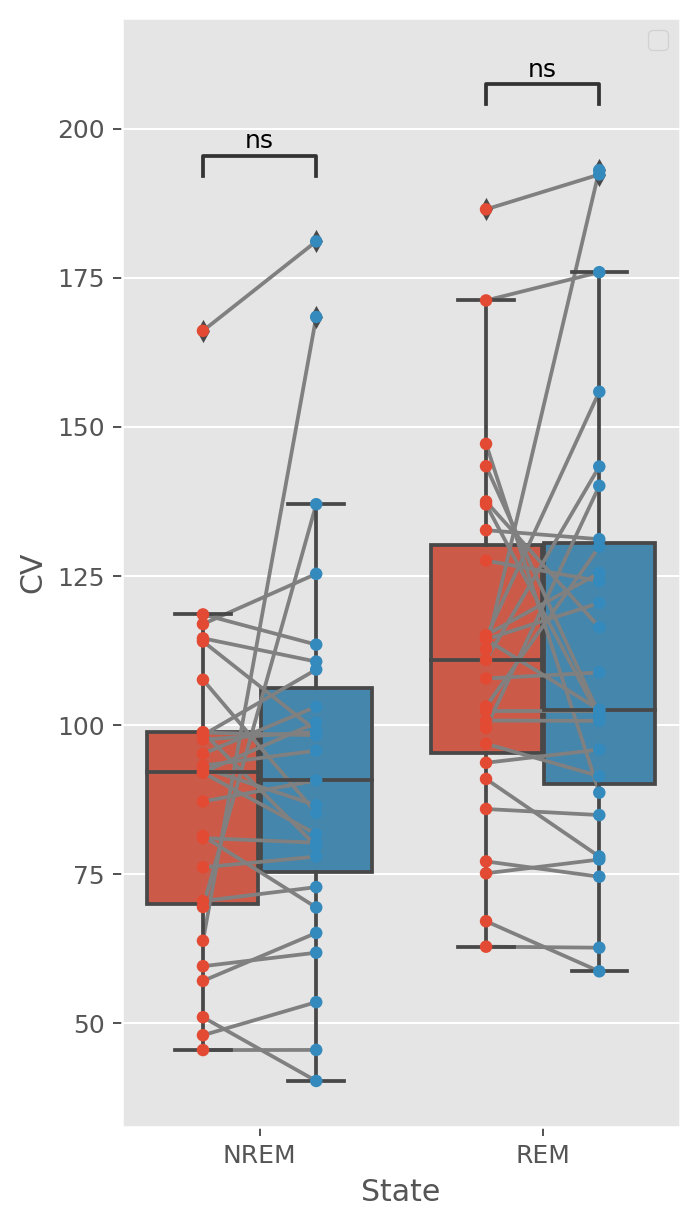

In [12]:
fig,ax = plt.subplots(figsize=(4,8),dpi = 180)
for i,s in enumerate(['NREM','REM']):
    values = np.array((df.First[df.State == s],df.Last[df.State == s]))
    n_values = values.shape[1]
    x = [[i-0.20]*n_values,[i+0.20]*n_values]
    plt.plot(x,values,'grey')

plotting_params = {'data': df_melt,
                   'y': 'CV',
                   'x':'State',
                   'dodge':True,
                   'hue':'epoch',
                   'order':['NREM','REM'],
                   'ax':ax}
sns.boxplot(**plotting_params)
plotting_params['jitter'] = 0
sns.stripplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Wilcoxon",comparisons_correction = 'Bonferroni').apply_and_annotate()
# sns.boxplot(data = df_melt,x = 'State',y = 'EIB',hue = 'epoch',dodge=True,order = ['NREM','REM'],ax = ax)
# sns.stripplot(data = df_melt,x = 'State',y = 'EIB',hue = 'epoch',dodge=True,order = ['NREM','REM'],jitter = 0,ax = ax)
plt.legend([])
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/CV/Parts/EIB_extended_sleep.svg')